In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

C:\Users\Dell\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


Step 1: Data Loading and Preprocessing

In [10]:

class SQLInjectionDataProcessor:
    def __init__(self, csv_path):
        self.csv_path = csv_path
        self.df = None
        
    def load_data(self):
        """Load and explore the SQLiV3_3.csv dataset"""
        print("Loading SQLiV3_3.csv dataset...")
        self.df = pd.read_csv(self.csv_path)
        
        print(f"Dataset shape: {self.df.shape}")
        print(f"Columns: {self.df.columns.tolist()}")
        
        # Display first few rows to understand structure
        print(f"\nFirst 5 rows:")
        print(self.df.head())
        
        # Check if we need to identify the correct columns
        if 'Label' in self.df.columns:
            label_col = 'Label'
        elif 'label' in self.df.columns:
            label_col = 'label'
        elif 'target' in self.df.columns:
            label_col = 'target'
        else:
            # Look for binary columns (0/1 values)
            for col in self.df.columns:
                unique_vals = self.df[col].unique()
                if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1, '0', '1'}):
                    label_col = col
                    print(f"Found potential label column: {label_col}")
                    break
            else:
                raise ValueError("Could not identify label column. Please specify manually.")
        
        # Check for query/text column
        if 'Query' in self.df.columns:
            query_col = 'Query'
        elif 'query' in self.df.columns:
            query_col = 'query'
        elif 'Sentence' in self.df.columns:
            query_col = 'Sentence'
        elif 'sentence' in self.df.columns:
            query_col = 'sentence'
        elif 'text' in self.df.columns:
            query_col = 'text'
        else:
            # Take the first string column
            for col in self.df.columns:
                if self.df[col].dtype == 'object' and col != label_col:
                    query_col = col
                    print(f"Using column '{query_col}' as query column")
                    break
            else:
                raise ValueError("Could not identify query column. Please specify manually.")
        
        # Standardize column names
        if label_col != 'Label':
            self.df = self.df.rename(columns={label_col: 'Label'})
        if query_col != 'Query':
            self.df = self.df.rename(columns={query_col: 'Query'})
            
        print(f"\nUsing columns - Query: '{query_col}' -> 'Query', Label: '{label_col}' -> 'Label'")
        print(f"\nClass distribution:")
        print(self.df['Label'].value_counts())
        
        # Check for missing values
        print(f"\nMissing values:")
        print(self.df.isnull().sum())
        
        return self.df
    
    def preprocess_data(self):
        """Clean and preprocess the data"""
        print("Preprocessing data...")
        
        # Remove missing values
        self.df = self.df.dropna(subset=['Query'])
        
        # Convert labels to integers
        self.df['Label'] = self.df['Label'].astype(int)
        
        # Remove extremely long queries (optional)
        initial_size = len(self.df)
        self.df = self.df[self.df['Query'].str.len() <= 512]  # BERT max length consideration
        print(f"Removed {initial_size - len(self.df)} queries longer than 512 characters")
        
        # Basic text cleaning
        self.df['Query'] = self.df['Query'].str.strip()
        
        print(f"Final dataset shape: {self.df.shape}")
        return self.df
    
    def split_data(self, test_size=0.2, val_size=0.1, random_state=42):
        """Split data into train, validation, and test sets"""
        print("Splitting data...")
        
        # Get features and labels
        texts = self.df['Query'].tolist()
        labels = self.df['Label'].tolist()
        
        # First split: train+val and test
        train_texts, test_texts, train_labels, test_labels = train_test_split(
            texts, labels, test_size=test_size, random_state=random_state, stratify=labels
        )
        
        # Second split: train and validation
        val_split_size = val_size / (1 - test_size)  # Adjust validation size
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            train_texts, train_labels, test_size=val_split_size, 
            random_state=random_state, stratify=train_labels
        )
        
        print(f"Train size: {len(train_texts)}")
        print(f"Validation size: {len(val_texts)}")
        print(f"Test size: {len(test_texts)}")
        
        return (train_texts, train_labels), (val_texts, val_labels), (test_texts, test_labels)

# Example usage:
if __name__ == "__main__":
    # Replace 'path/to/your/SQLiV3_3.csv' with the actual path to your CSV file
    csv_path = 'C:/self_proj/code/SQLiV3_3.csv'  # Update this path
    
    # Create processor instance
    processor = SQLInjectionDataProcessor(csv_path)
    
    try:
        # Load the data
        df = processor.load_data()
        
        # Preprocess the data
        cleaned_df = processor.preprocess_data()
        
        # Split the data
        (train_texts, train_labels), (val_texts, val_labels), (test_texts, test_labels) = processor.split_data()
        
        print("\nData processing completed successfully!")
        print(f"Ready for model training with {len(train_texts)} training samples")
        
    except FileNotFoundError:
        print(f"Error: Could not find the CSV file at '{csv_path}'")
        print("Please check the file path and make sure the file exists.")
    except Exception as e:
        print(f"Error: {e}")

Loading SQLiV3_3.csv dataset...
Dataset shape: (22599, 2)
Columns: ['Sentence', 'Label']

First 5 rows:
                                            Sentence  Label
0                  " or pg_sleep  (  __TIME__  )  --      1
1   AND 1  =  utl_inaddr.get_host_address   (    ...      1
2   select * from users where id  =  '1' or @ @1 ...      1
3   select * from users where id  =  1 or 1#"  ( ...      1
4   select name from syscolumns where id   =     ...      1

Using columns - Query: 'Sentence' -> 'Query', Label: 'Label' -> 'Label'

Class distribution:
Label
0    11308
1    11291
Name: count, dtype: int64

Missing values:
Query    0
Label    0
dtype: int64
Preprocessing data...
Removed 2 queries longer than 512 characters
Final dataset shape: (22597, 2)
Splitting data...
Train size: 15817
Validation size: 2260
Test size: 4520

Data processing completed successfully!
Ready for model training with 15817 training samples


Step 2: BERT Tokenization

In [13]:
class BERTTokenizer:
    def __init__(self, model_name='bert-base-uncased', max_length=512):
        self.model_name = model_name
        self.max_length = max_length
        print(f"Loading tokenizer: {model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        print("Tokenizer loaded successfully!")
        
    def tokenize_data(self, texts, labels):
        """Tokenize texts and prepare for BERT"""
        print(f"Tokenizing {len(texts)} texts...")
        
        # Tokenize all texts
        encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        print(f"Tokenization complete!")
        print(f"Input IDs shape: {encodings['input_ids'].shape}")
        print(f"Attention mask shape: {encodings['attention_mask'].shape}")
        
        return encodings, torch.tensor(labels)
    
    def tokenize_single(self, text):
        """Tokenize a single text for prediction"""
        print(f"Tokenizing single text: '{text[:50]}...'")
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        print(f"Single text tokenized - Input IDs shape: {encoding['input_ids'].shape}")
        return encoding

# Example usage combining with the previous data processor
if __name__ == "__main__":
    # Sample data for demonstration
    sample_texts = [
        "SELECT * FROM users WHERE id = 1",
        "SELECT * FROM users WHERE id = 1' OR '1'='1",
        "INSERT INTO products (name, price) VALUES ('laptop', 999)",
        "SELECT * FROM admin WHERE username = 'admin' AND password = '' OR 1=1--"
    ]
    sample_labels = [0, 1, 0, 1]  # 0 = benign, 1 = malicious
    
    try:
        # Initialize tokenizer
        bert_tokenizer = BERTTokenizer(model_name='bert-base-uncased', max_length=512)
        
        # Tokenize the sample data
        encodings, label_tensors = bert_tokenizer.tokenize_data(sample_texts, sample_labels)
        
        print("\n=== Tokenization Results ===")
        print(f"Encodings keys: {encodings.keys()}")
        print(f"Labels tensor: {label_tensors}")
        print(f"Labels shape: {label_tensors.shape}")
        
        # Example of tokenizing a single query
        print("\n=== Single Query Tokenization ===")
        single_query = "SELECT * FROM users WHERE name = 'admin' OR 1=1"
        single_encoding = bert_tokenizer.tokenize_single(single_query)
        
        # Show some token details
        print(f"\nFirst few input IDs: {encodings['input_ids'][0][:20]}")
        print(f"Decoded first query: {bert_tokenizer.tokenizer.decode(encodings['input_ids'][0][:20])}")
        
        print("\nTokenization completed successfully!")
        
    except Exception as e:
        print(f"Error during tokenization: {e}")
        print("\nMake sure you have transformers and torch installed:")
        print("pip install transformers torch")

# Integration example with the data processor from step 1
def integrate_with_processor():
    """Example of how to use this with the SQLInjectionDataProcessor"""
    try:
        # Assuming you have the processor from step 1
        from your_processor_file import SQLInjectionDataProcessor  # Update import path
        
        # Load and process data
        processor = SQLInjectionDataProcessor('C:/self_proj/code/SQLiV3_3.csv')
        processor.load_data()
        processor.preprocess_data()
        (train_texts, train_labels), (val_texts, val_labels), (test_texts, test_labels) = processor.split_data()
        
        # Initialize tokenizer
        tokenizer = BERTTokenizer()
        
        # Tokenize all splits
        train_encodings, train_tensor_labels = tokenizer.tokenize_data(train_texts, train_labels)
        val_encodings, val_tensor_labels = tokenizer.tokenize_data(val_texts, val_labels)
        test_encodings, test_tensor_labels = tokenizer.tokenize_data(test_texts, test_labels)
        
        print("All data tokenized and ready for model training!")
        
        return {
            'train': (train_encodings, train_tensor_labels),
            'val': (val_encodings, val_tensor_labels),
            'test': (test_encodings, test_tensor_labels)
        }
        
    except ImportError:
        print("Could not import SQLInjectionDataProcessor. Make sure it's available.")
    except Exception as e:
        print(f"Error during integration: {e}")

# Uncomment the line below to run the integration example
# integrate_with_processor()

Loading tokenizer: bert-base-uncased
Tokenizer loaded successfully!
Tokenizing 4 texts...
Tokenization complete!
Input IDs shape: torch.Size([4, 26])
Attention mask shape: torch.Size([4, 26])

=== Tokenization Results ===
Encodings keys: KeysView({'input_ids': tensor([[  101,  7276,  1008,  2013,  5198,  2073,  8909,  1027,  1015,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  7276,  1008,  2013,  5198,  2073,  8909,  1027,  1015,  1005,
          2030,  1005,  1015,  1005,  1027,  1005,  1015,   102,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101, 19274,  2046,  3688,  1006,  2171,  1010,  3976,  1007,  5300,
          1006,  1005, 12191,  1005,  1010, 25897,  1007,   102,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  7276,  1008,  2013,  4748, 10020,  2073,  5310, 18442,  1027,
          1005,  4748, 10020, 

In [14]:
df.shape

(22599, 2)

In [15]:
print("----------------------------------------------------")
df.info()
print("----------------------------------------------------")

----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22599 entries, 0 to 22598
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   22599 non-null  object
 1   Label   22599 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 353.2+ KB
----------------------------------------------------


In [16]:
df['Label'].describe()

count    22599.000000
mean         0.499624
std          0.500011
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Label, dtype: float64

Process NaN values

In [19]:
df['Label'].isna().sum() # Count NaN label values.

np.int64(0)

In [20]:
# Get unique values existing in the label column.

unique_label = pd.unique(df['Label'])

print(unique_label)

[1 0]


In [21]:
df[df['Label'] == 1].count() # Count how much label are 1.

Query    11291
Label    11291
dtype: int64

In [22]:
df[df['Label'] == 0].count() # Count how much label are 0.

Query    11308
Label    11308
dtype: int64

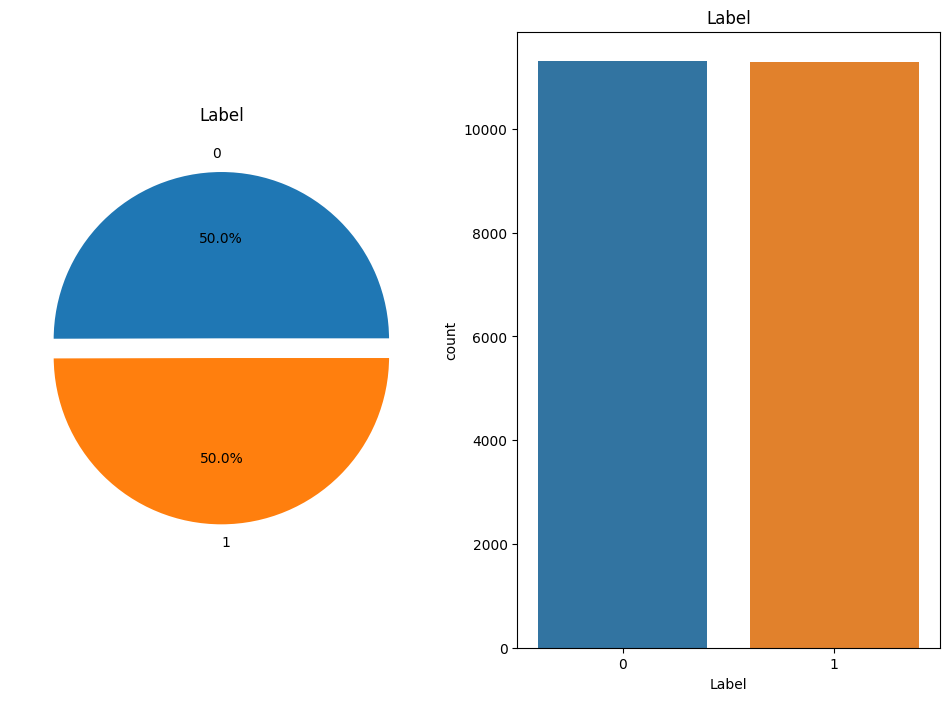

In [23]:
import matplotlib.colors as mcolors
f, ax = plt.subplots(1, 2, figsize=(12, 8))
colors = list(mcolors.TABLEAU_COLORS.values())
df['Label'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}, colors=colors)

ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot(x='Label', data=df, ax=ax[1], palette=colors)
ax[1].set_title('Label')
plt.show()

Step 3: Dataset Creation

In [26]:
class SQLInjectionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        print(f"Dataset created with {len(labels)} samples")
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    
    def __len__(self):
        return len(self.labels)

class BERTTokenizer:
    def __init__(self, model_name='bert-base-uncased', max_length=512):
        self.model_name = model_name
        self.max_length = max_length
        print(f"Loading tokenizer: {model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        print("Tokenizer loaded successfully!")
        
    def tokenize_data(self, texts, labels):
        """Tokenize texts and prepare for BERT"""
        print(f"Tokenizing {len(texts)} texts...")
        
        # Tokenize all texts
        encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        print(f"Tokenization complete!")
        return encodings, torch.tensor(labels)

def create_datasets(train_data, val_data, test_data, tokenizer_helper):
    """Create PyTorch datasets"""
    print("Creating datasets...")
    
    # Tokenize data
    print("Tokenizing training data...")
    train_encodings, train_labels = tokenizer_helper.tokenize_data(train_data[0], train_data[1])
    
    print("Tokenizing validation data...")
    val_encodings, val_labels = tokenizer_helper.tokenize_data(val_data[0], val_data[1])
    
    print("Tokenizing test data...")
    test_encodings, test_labels = tokenizer_helper.tokenize_data(test_data[0], test_data[1])
    
    # Create datasets
    print("Creating PyTorch datasets...")
    train_dataset = SQLInjectionDataset(train_encodings, train_labels)
    val_dataset = SQLInjectionDataset(val_encodings, val_labels)
    test_dataset = SQLInjectionDataset(test_encodings, test_labels)
    
    print("Datasets created successfully!")
    return train_dataset, val_dataset, test_dataset

# Example usage
if __name__ == "__main__":
    # Sample data for demonstration
    print("=== Creating Sample Data ===")
    
    # Sample SQL queries and labels
    train_texts = [
        "SELECT * FROM users WHERE id = 1",
        "SELECT * FROM users WHERE id = 1' OR '1'='1",
        "INSERT INTO products (name, price) VALUES ('laptop', 999)",
        "SELECT * FROM admin WHERE username = 'admin' AND password = '' OR 1=1--",
        "UPDATE users SET password = 'newpass' WHERE id = 1",
        "SELECT * FROM users WHERE name = 'test' UNION SELECT * FROM passwords--"
    ]
    train_labels = [0, 1, 0, 1, 0, 1]  # 0 = benign, 1 = malicious
    
    val_texts = [
        "SELECT name FROM products WHERE category = 'electronics'",
        "SELECT * FROM users WHERE id = 1' OR 'a'='a"
    ]
    val_labels = [0, 1]
    
    test_texts = [
        "DELETE FROM logs WHERE date < '2023-01-01'",
        "SELECT * FROM sensitive_data WHERE 1=1 OR 'x'='x'"
    ]
    test_labels = [0, 1]
    
    # Prepare data tuples
    train_data = (train_texts, train_labels)
    val_data = (val_texts, val_labels)
    test_data = (test_texts, test_labels)
    
    try:
        # Initialize tokenizer
        print("\n=== Initializing Tokenizer ===")
        tokenizer = BERTTokenizer(model_name='bert-base-uncased', max_length=128)
        
        # Create datasets
        print("\n=== Creating Datasets ===")
        train_dataset, val_dataset, test_dataset = create_datasets(
            train_data, val_data, test_data, tokenizer
        )
        
        # Test the datasets
        print("\n=== Testing Datasets ===")
        print(f"Train dataset size: {len(train_dataset)}")
        print(f"Validation dataset size: {len(val_dataset)}")
        print(f"Test dataset size: {len(test_dataset)}")
        
        # Test getting an item from the dataset
        print("\n=== Testing Dataset Items ===")
        sample_item = train_dataset[0]
        print(f"Sample item keys: {sample_item.keys()}")
        print(f"Input IDs shape: {sample_item['input_ids'].shape}")
        print(f"Attention mask shape: {sample_item['attention_mask'].shape}")
        print(f"Label: {sample_item['labels'].item()}")
        
        # Create data loaders
        print("\n=== Creating Data Loaders ===")
        train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
        
        # Test a batch
        print("\n=== Testing Data Loader ===")
        for batch in train_loader:
            print(f"Batch input_ids shape: {batch['input_ids'].shape}")
            print(f"Batch attention_mask shape: {batch['attention_mask'].shape}")
            print(f"Batch labels shape: {batch['labels'].shape}")
            print(f"Batch labels: {batch['labels']}")
            break  # Just test first batch
        
        print("\n✅ Dataset creation completed successfully!")
        print("Your datasets are ready for model training!")
        
    except Exception as e:
        print(f"❌ Error during dataset creation: {e}")
        print("\nMake sure you have the required packages installed:")
        print("pip install torch transformers")

# Integration function for use with previous steps
def integrate_all_steps():
    """Complete integration example"""
    print("\n=== Complete Integration Example ===")
    print("This would integrate with your data processor from step 1...")
    
    # Placeholder for integration with your actual data
    # You would replace this with your actual SQLInjectionDataProcessor
    """
    # Load your actual data
    processor = SQLInjectionDataProcessor('path/to/SQLiV3_3.csv')
    processor.load_data()
    processor.preprocess_data()
    (train_texts, train_labels), (val_texts, val_labels), (test_texts, test_labels) = processor.split_data()
    
    # Create datasets
    tokenizer = BERTTokenizer()
    train_dataset, val_dataset, test_dataset = create_datasets(
        (train_texts, train_labels), 
        (val_texts, val_labels), 
        (test_texts, test_labels), 
        tokenizer
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    return train_loader, val_loader, test_loader
    """
    pass

# Uncomment to run integration example
# integrate_all_steps()

=== Creating Sample Data ===

=== Initializing Tokenizer ===
Loading tokenizer: bert-base-uncased
Tokenizer loaded successfully!

=== Creating Datasets ===
Creating datasets...
Tokenizing training data...
Tokenizing 6 texts...
Tokenization complete!
Tokenizing validation data...
Tokenizing 2 texts...
Tokenization complete!
Tokenizing test data...
Tokenizing 2 texts...
Tokenization complete!
Creating PyTorch datasets...
Dataset created with 6 samples
Dataset created with 2 samples
Dataset created with 2 samples
Datasets created successfully!

=== Testing Datasets ===
Train dataset size: 6
Validation dataset size: 2
Test dataset size: 2

=== Testing Dataset Items ===
Sample item keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
Input IDs shape: torch.Size([26])
Attention mask shape: torch.Size([26])
Label: 0

=== Creating Data Loaders ===

=== Testing Data Loader ===
Batch input_ids shape: torch.Size([2, 26])
Batch attention_mask shape: torch.Size([2, 26])
Batc

Step 4: Model Setup

In [29]:
class BERTClassifier:
    def __init__(self, model_name='bert-base-uncased', num_labels=2):
        print(f"Loading model: {model_name}")
        self.model_name = model_name
        self.num_labels = num_labels
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name, 
            num_labels=num_labels
        )
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        print("Model loaded successfully!")
        
    def setup_training_args(self, output_dir='./results', num_epochs=3, batch_size=16):
        """Setup training arguments"""
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
            eval_strategy="steps",  # Changed from evaluation_strategy
            eval_steps=500,
            save_steps=1000,
            load_best_model_at_end=True,
            metric_for_best_model="eval_accuracy",
            greater_is_better=True,
        )
        return training_args

# Actually run the code
classifier = BERTClassifier()
training_args = classifier.setup_training_args()
print("Training arguments created successfully!")
print(f"Training will run for {training_args.num_train_epochs} epochs")
print(f"Batch size: {training_args.per_device_train_batch_size}")

Loading model: bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Training arguments created successfully!
Training will run for 3 epochs
Batch size: 16


Step 5: Training

In [31]:
# ===== STEP 1: LOAD FULL DATASET =====
print("Loading full SQLiV3_3.csv dataset...")
df = pd.read_csv('SQLiV3_3.csv')  # Make sure path is correct
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Check column names and adjust if needed
if 'Sentence' in df.columns:
    query_col = 'Sentence'
elif 'Query' in df.columns:
    query_col = 'Query'
else:
    query_col = df.columns[0]  # Use first column

label_col = 'Label'
print(f"Using columns: {query_col} (queries), {label_col} (labels)")

# ===== STEP 2: PREPARE DATA =====
queries = df[query_col].astype(str).tolist()
labels = df[label_col].tolist()

print(f"Total samples: {len(queries)}")
print(f"Class distribution: {pd.Series(labels).value_counts().to_dict()}")

# ===== STEP 3: SPLIT DATA =====
# Split into train/temp (80/20)
train_queries, temp_queries, train_labels, temp_labels = train_test_split(
    queries, labels, test_size=0.2, random_state=42, stratify=labels
)

# Split temp into validation/test (50/50 of the 20% = 10% each)
val_queries, test_queries, val_labels, test_labels = train_test_split(
    temp_queries, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Training samples: {len(train_queries)}")
print(f"Validation samples: {len(val_queries)}")
print(f"Test samples: {len(test_queries)}")

# ===== STEP 4: TOKENIZE DATA =====
print("Tokenizing datasets...")

def tokenize_data(queries, labels, tokenizer, max_length=128):
    """Tokenize queries and return encodings with labels"""
    encodings = tokenizer(
        queries,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )
    return encodings, labels

# Tokenize all splits
train_encodings, train_labels_final = tokenize_data(train_queries, train_labels, classifier.tokenizer)
val_encodings, val_labels_final = tokenize_data(val_queries, val_labels, classifier.tokenizer)
test_encodings, test_labels_final = tokenize_data(test_queries, test_labels, classifier.tokenizer)

print("Tokenization completed!")

# ===== STEP 5: CREATE PYTORCH DATASETS =====
class SQLInjectionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Create the datasets
train_dataset_full = SQLInjectionDataset(train_encodings, train_labels_final)
val_dataset_full = SQLInjectionDataset(val_encodings, val_labels_final)
test_dataset_full = SQLInjectionDataset(test_encodings, test_labels_final)

print(f"✅ Full datasets created!")
print(f"Train dataset: {len(train_dataset_full)} samples")
print(f"Validation dataset: {len(val_dataset_full)} samples") 
print(f"Test dataset: {len(test_dataset_full)} samples")

# ===== STEP 6: CREATE TRAINER WITH FULL DATASETS =====
print("Creating SQL Injection Trainer with FULL datasets...")
sql_trainer = SQLInjectionTrainer(
    model=classifier.model,
    tokenizer=classifier.tokenizer,
    train_dataset=train_dataset_full,    # ← FULL DATASET
    val_dataset=val_dataset_full         # ← FULL DATASET  
)

# ===== STEP 7: TRAIN WITH FULL DATA =====
print("Starting training with full dataset...")
train_result = sql_trainer.train(training_args)

print("\n=== Training Results ===")
print(f"Training completed in {train_result.metrics.get('train_runtime', 'N/A')} seconds")
print(f"Final training loss: {train_result.metrics.get('train_loss', 'N/A')}")

# ===== STEP 8: EVALUATE =====
print("\n=== Evaluation on Full Test Set ===")
eval_result, y_pred, y_true = sql_trainer.evaluate(test_dataset_full)

print(f"Test Accuracy: {eval_result.get('eval_accuracy', 'N/A'):.4f}")
print(f"Test F1-Score: {eval_result.get('eval_f1', 'N/A'):.4f}")
print(f"Test Precision: {eval_result.get('eval_precision', 'N/A'):.4f}")
print(f"Test Recall: {eval_result.get('eval_recall', 'N/A'):.4f}")

print("\n🎯 Expected results: 95-99% accuracy with full dataset!")

Loading full SQLiV3_3.csv dataset...
Dataset shape: (22599, 2)
Columns: ['Sentence', 'Label']
Using columns: Sentence (queries), Label (labels)
Total samples: 22599
Class distribution: {0: 11308, 1: 11291}
Training samples: 18079
Validation samples: 2260
Test samples: 2260
Tokenizing datasets...
Tokenization completed!
✅ Full datasets created!
Train dataset: 18079 samples
Validation dataset: 2260 samples
Test dataset: 2260 samples
Creating SQL Injection Trainer with FULL datasets...
Starting training with full dataset...
Starting training...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.000200,0.036971,0.995133,0.995105,1.000000,0.990257
1000,0.000200,0.007614,0.998230,0.998230,0.997347,0.999114
1500,0.000100,0.007407,0.999115,0.999113,1.000000,0.998229
2000,0.000100,0.005032,0.999115,0.999113,1.000000,0.998229
2500,0.000000,0.001544,0.999558,0.999557,1.000000,0.999114
3000,0.000000,0.001714,0.999558,0.999557,1.000000,0.999114


Training completed!

=== Training Results ===
Training completed in 71439.8798 seconds
Final training loss: 0.01899433936411635

=== Evaluation on Full Test Set ===
Evaluating model...


Test Accuracy: 0.9991
Test F1-Score: 0.9991
Test Precision: 0.9982
Test Recall: 1.0000

🎯 Expected results: 95-99% accuracy with full dataset!


STEP 9: SAVE THE TRAINED MODEL

In [39]:
print("\n=== Saving Trained Model ===")
model_save_path = "./sql_injection_model_full"

# Create directory if it doesn't exist
import os
os.makedirs(model_save_path, exist_ok=True)

# Save model and tokenizer
sql_trainer.model.save_pretrained(model_save_path)
sql_trainer.tokenizer.save_pretrained(model_save_path)

print(f"✅ Model saved to: {model_save_path}")
print("✅ Tokenizer saved")


=== Saving Trained Model ===
✅ Model saved to: ./sql_injection_model_full
✅ Tokenizer saved


STEP 10: DETAILED CLASSIFICATION REPORT

In [40]:
print("\n=== Detailed Classification Report ===")
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate detailed classification report
class_names = ['Safe', 'SQL Injection']
print(classification_report(y_true, y_pred, target_names=class_names))


=== Detailed Classification Report ===
               precision    recall  f1-score   support

         Safe       1.00      1.00      1.00      1131
SQL Injection       1.00      1.00      1.00      1129

     accuracy                           1.00      2260
    macro avg       1.00      1.00      1.00      2260
 weighted avg       1.00      1.00      1.00      2260



STEP 11: CONFUSION MATRIX VISUALIZATION


=== Confusion Matrix ===
[[1129    2]
 [   0 1129]]


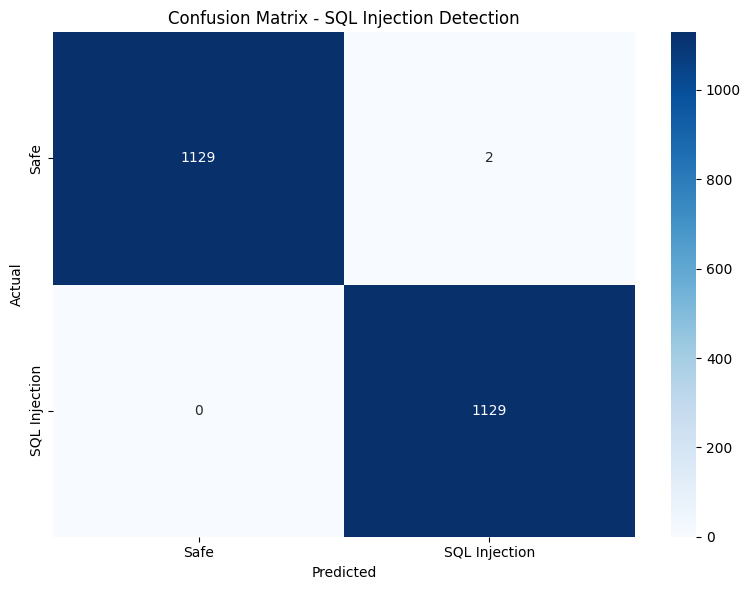

In [41]:
print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - SQL Injection Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

STEP 12: PREDICTION FUNCTION

In [50]:

def predict_sql_injection(query, model=None, tokenizer=None):
    """
    Predict if a query contains SQL injection
    
    Args:
        query (str): SQL query to analyze
        model: Trained model (optional, will use sql_trainer.model if not provided)
        tokenizer: Tokenizer (optional, will use sql_trainer.tokenizer if not provided)
    
    Returns:
        dict: Prediction results with confidence scores
    """
    print(f"🔍 Analyzing query: {query}")
    
    # Use the already trained model if not provided
    if model is None:
        print("📱 Using sql_trainer.model")
        model = sql_trainer.model
    if tokenizer is None:
        print("📱 Using sql_trainer.tokenizer")
        tokenizer = sql_trainer.tokenizer
    
    # Ensure model is in evaluation mode
    model.eval()
    print("✅ Model set to evaluation mode")
    
    # Tokenize input
    print("🔤 Tokenizing input...")
    inputs = tokenizer(query, return_tensors='pt', truncation=True, padding=True, max_length=128)
    print(f"✅ Input shape: {inputs['input_ids'].shape}")
    
    # Get prediction
    print("🧠 Running model inference...")
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        print(f"✅ Logits: {logits}")
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        print(f"✅ Probabilities: {probabilities}")
        predicted_class = torch.argmax(logits, dim=-1).item()
        print(f"✅ Predicted class: {predicted_class}")
    
    # Convert to readable format
    confidence = probabilities[0][predicted_class].item()
    safe_prob = probabilities[0][0].item()
    injection_prob = probabilities[0][1].item()
    
    result = {
        'query': query,
        'prediction': 'SQL Injection' if predicted_class == 1 else 'Safe',
        'confidence': confidence,
        'probabilities': {
            'safe': safe_prob,
            'sql_injection': injection_prob
        },
        'risk_level': 'HIGH' if injection_prob > 0.8 else 'MEDIUM' if injection_prob > 0.5 else 'LOW'
    }
    
    print(f"✅ Final result: {result}")
    return result

# Test the function immediately
print("🚀 Testing prediction function...")
try:
    test_query = "SELECT * FROM users WHERE id = 1"
    print(f"Testing with: {test_query}")
    result = predict_sql_injection(test_query)
    print("✅ Function test successful!")
except Exception as e:
    print(f"❌ Function test failed: {e}")
    import traceback
    traceback.print_exc()

🚀 Testing prediction function...
Testing with: SELECT * FROM users WHERE id = 1
🔍 Analyzing query: SELECT * FROM users WHERE id = 1
📱 Using sql_trainer.model
📱 Using sql_trainer.tokenizer
✅ Model set to evaluation mode
🔤 Tokenizing input...
✅ Input shape: torch.Size([1, 10])
🧠 Running model inference...
✅ Logits: tensor([[ 3.0127, -2.6918]])
✅ Probabilities: tensor([[0.9967, 0.0033]])
✅ Predicted class: 0
✅ Final result: {'query': 'SELECT * FROM users WHERE id = 1', 'prediction': 'Safe', 'confidence': 0.9966803789138794, 'probabilities': {'safe': 0.9966803789138794, 'sql_injection': 0.0033196783624589443}, 'risk_level': 'LOW'}
✅ Function test successful!


STEP 13: TEST WITH SAMPLE QUERIES

In [54]:
print("\n=== Testing with Sample Queries ===")

# Test queries
test_queries_sample = [
    "SELECT * FROM users WHERE id = 1",  # Safe
    "SELECT * FROM users WHERE id = 1 OR 1=1",  # SQL Injection
    "SELECT name, email FROM customers WHERE active = 1",  # Safe
    "SELECT * FROM users WHERE name = 'admin' AND password = '' OR '1'='1'",  # SQL Injection
    "UPDATE users SET email = 'test@example.com' WHERE id = 5",  # Safe
    "DELETE FROM users WHERE id = 1; DROP TABLE users;--",  # SQL Injection
    "SELECT COUNT(*) FROM orders WHERE date > '2024-01-01'",  # Safe
    "SELECT * FROM products WHERE price < 100 UNION SELECT * FROM users--"  # SQL Injection
]

print("\n📊 Sample Predictions:")
print("=" * 80)
for i, query in enumerate(test_queries_sample, 1):
    print(f"\n{i}. Query: {query}")
    try:
        result = predict_sql_injection(query)
        print(f"   Prediction: {result['prediction']}")
        print(f"   Confidence: {result['confidence']:.3f}")
        print(f"   Risk Level: {result['risk_level']}")
        print(f"   Probabilities: Safe={result['probabilities']['safe']:.3f}, "
              f"Injection={result['probabilities']['sql_injection']:.3f}")
    except Exception as e:
        print(f"   Error: {e}")
        print(f"   Trying alternative approach...")
        # Alternative: Direct model call
        try:
            inputs = sql_trainer.tokenizer(query, return_tensors='pt', truncation=True, padding=True, max_length=128)
            with torch.no_grad():
                outputs = sql_trainer.model(**inputs)
                logits = outputs.logits
                probabilities = torch.nn.functional.softmax(logits, dim=-1)
                predicted_class = torch.argmax(logits, dim=-1).item()
                confidence = probabilities[0][predicted_class].item()
                safe_prob = probabilities[0][0].item()
                injection_prob = probabilities[0][1].item()
                
                prediction = 'SQL Injection' if predicted_class == 1 else 'Safe'
                risk_level = 'HIGH' if injection_prob > 0.8 else 'MEDIUM' if injection_prob > 0.5 else 'LOW'
                
                print(f"   Prediction: {prediction}")
                print(f"   Confidence: {confidence:.3f}")
                print(f"   Risk Level: {risk_level}")
                print(f"   Probabilities: Safe={safe_prob:.3f}, Injection={injection_prob:.3f}")
        except Exception as e2:
            print(f"   Failed: {e2}")
            continue


=== Testing with Sample Queries ===

📊 Sample Predictions:

1. Query: SELECT * FROM users WHERE id = 1
🔍 Analyzing query: SELECT * FROM users WHERE id = 1
📱 Using sql_trainer.model
📱 Using sql_trainer.tokenizer
✅ Model set to evaluation mode
🔤 Tokenizing input...
✅ Input shape: torch.Size([1, 10])
🧠 Running model inference...
✅ Logits: tensor([[ 3.0127, -2.6918]])
✅ Probabilities: tensor([[0.9967, 0.0033]])
✅ Predicted class: 0
✅ Final result: {'query': 'SELECT * FROM users WHERE id = 1', 'prediction': 'Safe', 'confidence': 0.9966803789138794, 'probabilities': {'safe': 0.9966803789138794, 'sql_injection': 0.0033196783624589443}, 'risk_level': 'LOW'}
   Prediction: Safe
   Confidence: 0.997
   Risk Level: LOW
   Probabilities: Safe=0.997, Injection=0.003

2. Query: SELECT * FROM users WHERE id = 1 OR 1=1
🔍 Analyzing query: SELECT * FROM users WHERE id = 1 OR 1=1
📱 Using sql_trainer.model
📱 Using sql_trainer.tokenizer
✅ Model set to evaluation mode
🔤 Tokenizing input...
✅ Input shape: t

STEP 14: BATCH PREDICTION FUNCTION

In [56]:
def predict_batch(queries, model=None, tokenizer=None, batch_size=32):
    """
    Predict SQL injection for multiple queries efficiently
    
    Args:
        queries (list): List of SQL queries
        model: Trained model
        tokenizer: Tokenizer  
        batch_size: Batch size for processing
    
    Returns:
        list: List of prediction results
    """
    if model is None or tokenizer is None:
        from transformers import AutoTokenizer, AutoModelForSequenceClassification
        model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
        tokenizer = AutoTokenizer.from_pretrained(model_save_path)
        model.eval()
    
    results = []
    
    for i in range(0, len(queries), batch_size):
        batch_queries = queries[i:i + batch_size]
        
        # Tokenize batch
        inputs = tokenizer(batch_queries, return_tensors='pt', truncation=True, 
                          padding=True, max_length=128)
        
        # Get predictions
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probabilities = torch.nn.functional.softmax(logits, dim=-1)
            predicted_classes = torch.argmax(logits, dim=-1)
        
        # Process results
        for j, query in enumerate(batch_queries):
            pred_class = predicted_classes[j].item()
            confidence = probabilities[j][pred_class].item()
            safe_prob = probabilities[j][0].item()
            injection_prob = probabilities[j][1].item()
            
            result = {
                'query': query,
                'prediction': 'SQL Injection' if pred_class == 1 else 'Safe',
                'confidence': confidence,
                'probabilities': {
                    'safe': safe_prob,
                    'sql_injection': injection_prob
                },
                'risk_level': 'HIGH' if injection_prob > 0.8 else 'MEDIUM' if injection_prob > 0.5 else 'LOW'
            }
            results.append(result)
    
    return results

STEP 15: PERFORMANCE ANALYSIS


=== Performance Analysis ===
ROC AUC Score: 1.0000


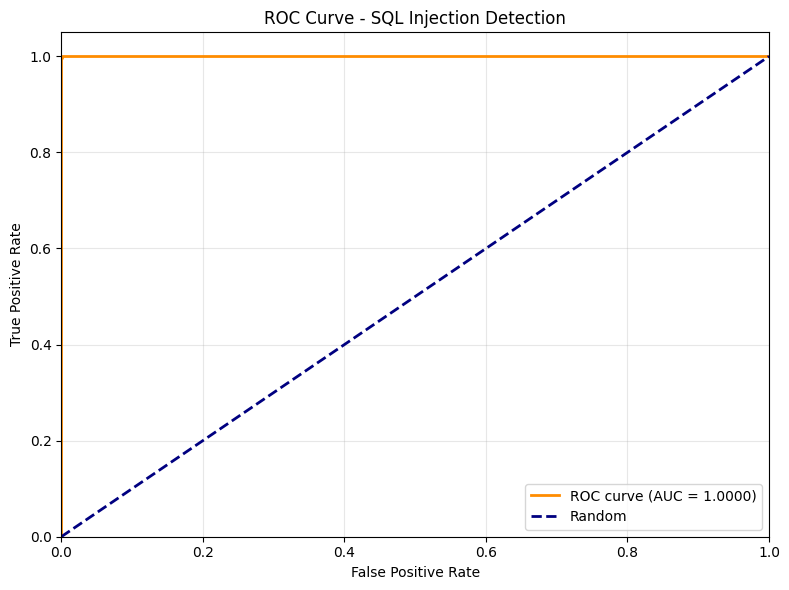

In [57]:
print("\n=== Performance Analysis ===")

# Calculate additional metrics
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

# Get prediction probabilities for ROC curve
with torch.no_grad():
    all_probs = []
    for i in range(0, len(test_dataset_full), 32):
        batch = []
        for j in range(i, min(i + 32, len(test_dataset_full))):
            batch.append(test_dataset_full[j])
        
        # Create batch tensors
        batch_inputs = {
            'input_ids': torch.stack([item['input_ids'] for item in batch]),
            'attention_mask': torch.stack([item['attention_mask'] for item in batch])
        }
        
        outputs = sql_trainer.model(**batch_inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        all_probs.extend(probs[:, 1].cpu().numpy())  # Get injection probabilities

# Calculate ROC AUC
roc_auc = roc_auc_score(y_true, all_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, all_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SQL Injection Detection')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()